In [332]:
import pandas as pd
import seaborn as sns
from statannot.statannot import add_stat_annotation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from evaluate import load
from statistics import mean 

#### BERTSCORE

In [276]:
eval = pd.read_csv("eval_total.csv")

In [371]:
eval[['coherence', 'completeness', 'correctness', 'naturalness', 'eval', 'model']].groupby(["eval", 'model']).mean()

coherence  completeness  correctness  naturalness
eval  model                                                     
gpt   llama     7.776876      6.253550     7.182556     8.352941
      medpalm   8.754564      7.267748     8.058824     9.208925
llama llama     7.985801      5.610548     7.405680     8.160243
      medpalm   8.843813      6.793103     8.302231     8.649087

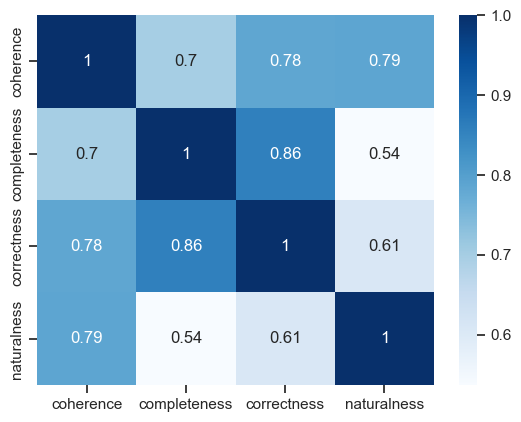

In [385]:
sns.heatmap(eval[['coherence', 'completeness', 'correctness', 'naturalness']].corr(), annot = True, cmap = "Blues")
#plt.savefig("heatmap.pdf")

In [277]:
x_order = ["correctness", "completeness", "coherence", "naturalness"]

# Melt the DataFrame to long format
eval_melted = eval.melt(id_vars=['question','gold answer','prediction','reason', 'model', 'eval'], value_vars=x_order, var_name='metric', value_name='rating')


In [242]:
eval_melted.head()

,question,gold answer,prediction,reason,model,eval,metric,rating
0,What is (are) Polycystic ovary syndrome ? (Als...,Polycystic ovary syndrome is a condition in wh...,Polycystic ovary syndrome (PCOS) is a common h...,The predicted answer is correct as it accurate...,Med-PaLM 2,GPT-4,correctness,10
1,What causes Polycystic ovary syndrome ? (Also ...,PCOS is linked to changes in hormone levels th...,Polycystic ovary syndrome (PCOS) is a complex ...,The predicted answer is partially correct and ...,Med-PaLM 2,GPT-4,correctness,7
2,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...,Noonan syndrome is primarily caused by mutatio...,The predicted answer is mostly correct and coh...,Med-PaLM 2,GPT-4,correctness,9
3,What are the complications of Noonan syndrome ?,- Buildup of fluid in tissues of body (lymphed...,The complications of Noonan syndrome can vary ...,The predicted answer is mostly correct and coh...,Med-PaLM 2,GPT-4,correctness,8
4,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...,Noonan syndrome is caused by genetic mutations...,The prediction is highly accurate and relevant...,Med-PaLM 2,GPT-4,correctness,9


In [278]:
eval_melted['eval'] = eval_melted['eval'].replace('gpt', 'GPT-4')
eval_melted['eval'] = eval_melted['eval'].replace('llama', 'Llama 3 70B')
eval_melted['model'] = eval_melted['model'].replace('medpalm', 'Med-PaLM 2')
eval_melted['model'] = eval_melted['model'].replace('llama', 'Llama 3 8B')

In [326]:
medpalm = eval[(eval['model'] == 'medpalm') & (eval['eval'] == "gpt")]
llama = eval[(eval['model'] == 'llama') & (eval['eval'] == "gpt")].reset_index(drop = True)

In [328]:
llama.head()

,question,gold answer,prediction,model,eval,correctness,coherence,naturalness,completeness,reason
0,What is (are) Polycystic ovary syndrome ? (Als...,Polycystic ovary syndrome is a condition in wh...,Polycystic ovary syndrome (PCOS) is a conditio...,llama,gpt,10,10,10,10,The predicted answer is correct as it accurate...
1,What causes Polycystic ovary syndrome ? (Also ...,PCOS is linked to changes in hormone levels th...,The cause of polycystic ovary syndrome (PCOS) ...,llama,gpt,8,8,9,7,The predicted answer is mostly correct and coh...
2,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...,What causes Noonan syndrome? Noonan syndrome i...,llama,gpt,9,9,9,8,The predicted answer is mostly correct and coh...
3,What are the complications of Noonan syndrome ?,#NAME?,People with Noonan syndrome have an increased ...,llama,gpt,7,8,9,6,The predicted answer is partially correct and ...
4,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...,How is Noonan syndrome inherited? Noonan syndr...,llama,gpt,5,7,8,4,The predicted answer provides correct informat...


In [316]:
bertscore = load("bertscore")

In [329]:
bertscore_med = bertscore.compute(predictions=medpalm['prediction'], references=medpalm['gold answer'], lang="en") # precision, recall, f1score
bertscore_llama = bertscore.compute(predictions=llama['prediction'], references=llama['gold answer'], lang="en") # precision, recall, f1score

/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [335]:
med_precision = mean(bertscore_med['precision'])
med_recall = mean(bertscore_med['recall'])
med_f1 = mean(bertscore_med['f1'])
print("medpalm precision:", med_precision, "; recall:", med_recall, "; f1:", med_f1)

medpalm precision: 0.8548175844894703 ; recall: 0.8485281157928838 ; f1: 0.851119576433851


In [336]:
llama_precision = mean(bertscore_llama['precision'])
llama_recall = mean(bertscore_llama['recall'])
llama_f1 = mean(bertscore_llama['f1'])
print("llama precision:", llama_precision, "; recall:", llama_recall, "; f1:", llama_f1)

llama precision: 0.8542464738201659 ; recall: 0.8465887597076308 ; f1: 0.8496983638883362


#### f1 vs length

In [347]:
def mean_string_length(strings):
    total_length = 0
    length = []
    for string in strings:
        if type(string) == float:
            total_length += 0
            length.append(0)
        else:
            total_length += len(string)
            length.append(len(string))

    if len(strings) == 0:
        return 0  
    else:
        return total_length / len(strings), length

llama_pred = llama['prediction']
llama_mean, llama_len = mean_string_length(llama_pred)

med_pred = medpalm['prediction']
med_mean, med_len = mean_string_length(med_pred)

In [354]:
f1_df = pd.DataFrame()
f1_df['f1'] = bertscore_llama['f1'] + bertscore_med['f1']
f1_df['length'] = llama_len + med_len
f1_df['model'] = ["Llama 3 8B"]*len(llama_len) + ['Med-PaLM 2']*len(med_len)

/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

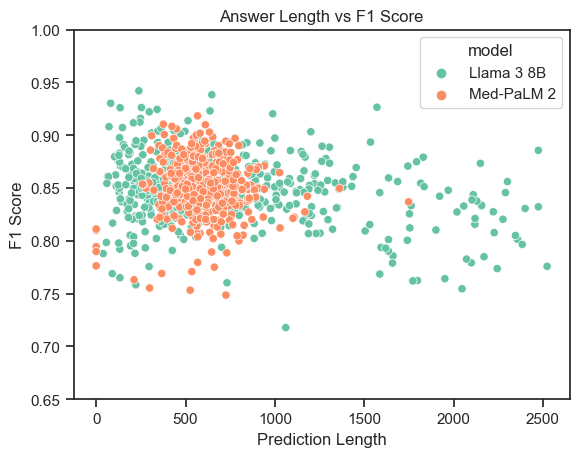

In [364]:
sns.scatterplot(x="length", y="f1", data = f1_df, hue = "model", palette = 'Set2')
plt.xlabel('Prediction Length')
plt.ylabel('F1 Score')
plt.title("Answer Length vs F1 Score")
plt.ylim(0.65,1)
#plt.savefig('length vs score.pdf')
plt.show()

#### compare the scores given by llama3 and gpt4

In [288]:
eval_medpalm = eval_melted[eval_melted['model'] == 'Med-PaLM 2']
eval_llama3 = eval_melted[eval_melted['model'] == 'Llama 3 8B']

/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

completeness_GPT-4 v.s. completeness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.087e-03 U_stat=1.374e+05
correctness_GPT-4 v.s. correctness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.043e-05 U_stat=1.030e+05
coherence_GPT-4 v.s. coherence_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.521e-03 U_stat=1.090e+05
naturalness_GPT-4 v.s. naturalness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.103e-35 U_stat=1.724e+05


/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

completeness_GPT-4 v.s. completeness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.073e-04 U_stat=1.383e+05
correctness_GPT-4 v.s. correctness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.059e-05 U_stat=1.032e+05
coherence_GPT-4 v.s. coherence_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.287e-05 U_stat=1.016e+05
naturalness_GPT-4 v.s. naturalness_Llama 3 70B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.679e-10 U_stat=1.483e+05


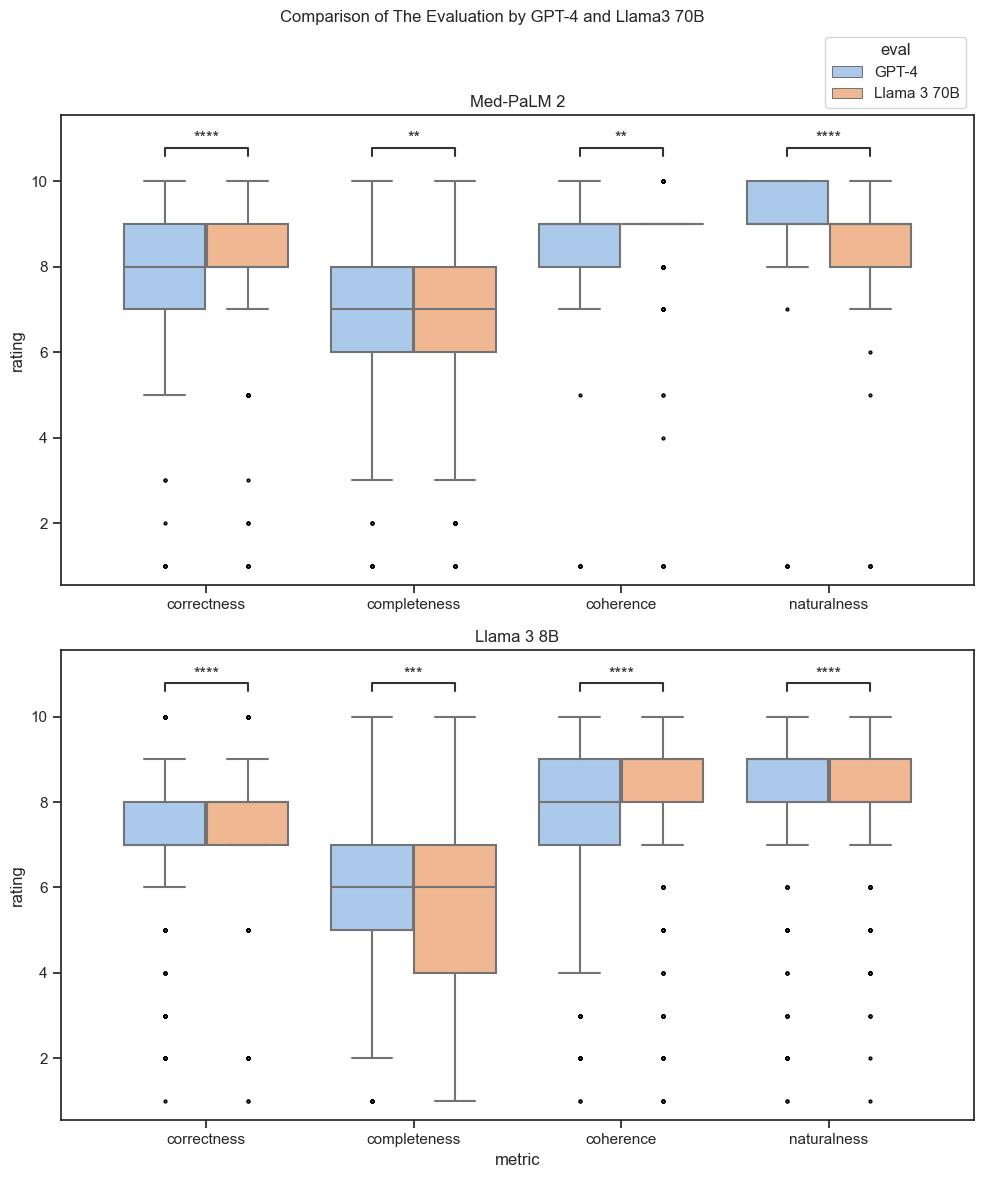

In [289]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
marker_style = dict(marker='o', markersize=2, markeredgecolor='black')
sns.boxplot(x="metric", y="rating",
            hue="eval",
            data=eval_medpalm, flierprops=marker_style, ax = ax1)
sns.move_legend(ax1, "lower right", bbox_to_anchor=(1, 1))

add_stat_annotation(ax1, data=eval_medpalm, x='metric', y='rating', hue='eval',
                    box_pairs=[(("correctness","GPT-4"), ("correctness","Llama 3 70B")),
                    (("coherence","GPT-4"), ("coherence","Llama 3 70B")),
                    (("naturalness","GPT-4"), ("naturalness","Llama 3 70B")),
                    (("completeness","GPT-4"), ("completeness","Llama 3 70B"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

ax1.set_title('Med-PaLM 2')
ax1.set_xlabel("")

sns.boxplot(x="metric", y="rating",
            hue="eval",
            data=eval_llama3, flierprops=marker_style, ax = ax2)
add_stat_annotation(ax2, data=eval_llama3, x='metric', y='rating', hue='eval',
                    box_pairs=[(("correctness","GPT-4"), ("correctness","Llama 3 70B")),
                    (("coherence","GPT-4"), ("coherence","Llama 3 70B")),
                    (("naturalness","GPT-4"), ("naturalness","Llama 3 70B")),
                    (("completeness","GPT-4"), ("completeness","Llama 3 70B"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
ax2.set_title('Llama 3 8B')
ax2.get_legend().set_visible(False)

fig.suptitle('Comparison of The Evaluation by GPT-4 and Llama3 70B', fontsize=12)
plt.tight_layout()
#plt.savefig('compare_gpt_llama.pdf')

plt.show()


#### compare the two models performances

In [283]:
llama_eval = eval_melted[eval_melted['eval'] == 'Llama 3 70B']
gpt_eval = eval_melted[eval_melted['eval'] == 'GPT-4']

/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

completeness_Med-PaLM 2 v.s. completeness_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.023e-13 U_stat=1.542e+05
correctness_Med-PaLM 2 v.s. correctness_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.008e-21 U_stat=1.603e+05
coherence_Med-PaLM 2 v.s. coherence_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.955e-24 U_stat=1.627e+05
naturalness_Med-PaLM 2 v.s. naturalness_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.835e-17 U_stat=1.566e+05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

completeness_Med-PaLM 2 v.s. completeness_Llama 3 8B: Mann-Whitney-Wilcoxo

/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/qiluzhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

correctness_Med-PaLM 2 v.s. correctness_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.618e-19 U_stat=1.607e+05
coherence_Med-PaLM 2 v.s. coherence_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.080e-34 U_stat=1.735e+05
naturalness_Med-PaLM 2 v.s. naturalness_Llama 3 8B: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.074e-33 U_stat=1.706e+05


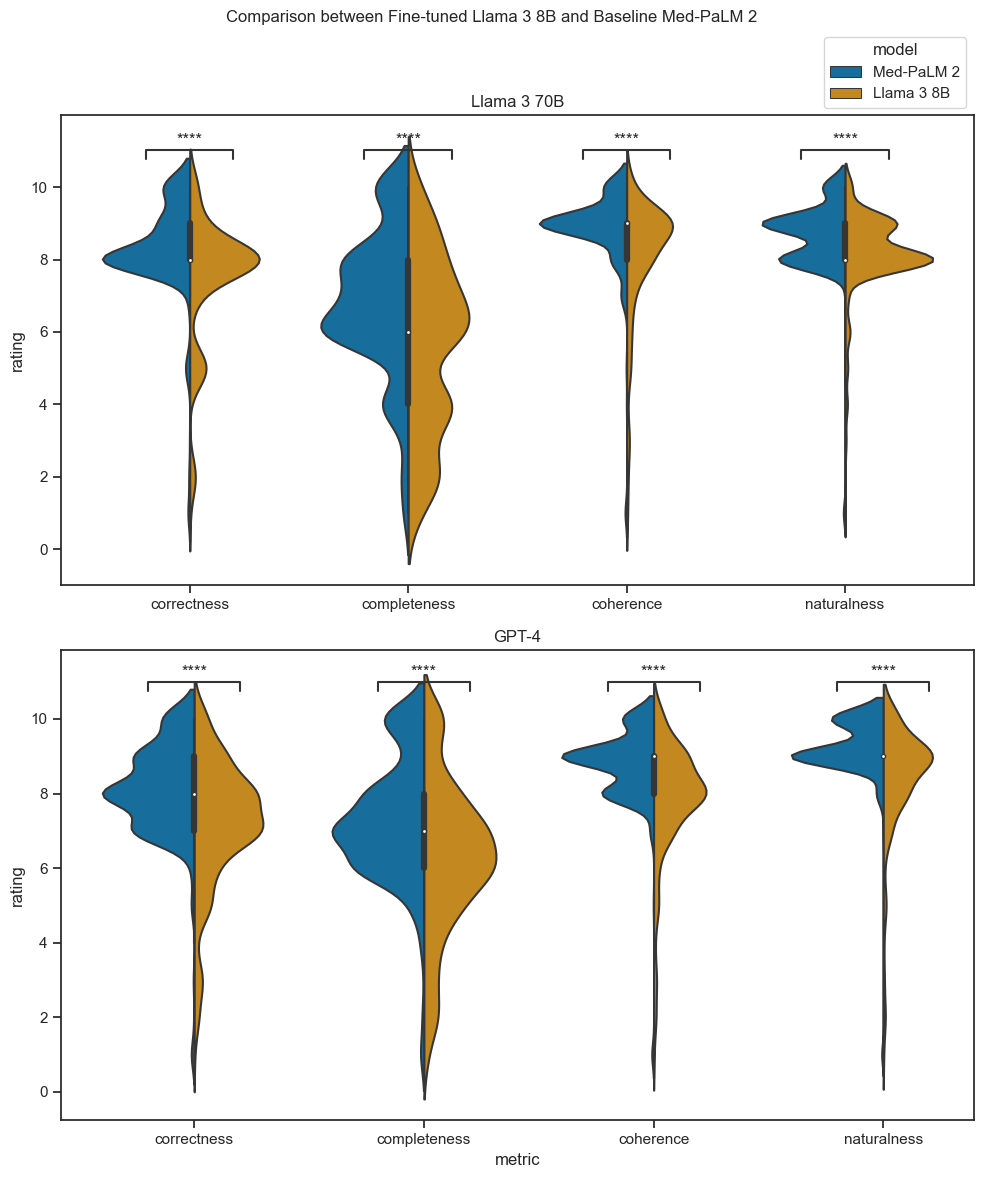

In [285]:
fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 12))


sns.violinplot(data=llama_eval, x="metric", y="rating", hue = 'model', split=True, ax = ax3, palette = "colorblind")
sns.move_legend(ax3, "lower right", bbox_to_anchor=(1, 1))
add_stat_annotation(ax3, data=llama_eval, x='metric', y='rating', hue='model',
                    box_pairs=[(("correctness","Med-PaLM 2"), ("correctness","Llama 3 8B")),
                    (("coherence","Med-PaLM 2"), ("coherence","Llama 3 8B")),
                    (("naturalness","Med-PaLM 2"), ("naturalness","Llama 3 8B")),
                    (("completeness","Med-PaLM 2"), ("completeness","Llama 3 8B"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

ax3.set_title('Llama 3 70B')
ax3.set_xlabel("")

sns.violinplot(data=gpt_eval, x="metric", y="rating", hue = 'model', split=True, ax = ax4, palette = "colorblind")
add_stat_annotation(ax4, data=gpt_eval, x='metric', y='rating', hue='model',
                    box_pairs=[(("correctness","Med-PaLM 2"), ("correctness","Llama 3 8B")),
                    (("coherence","Med-PaLM 2"), ("coherence","Llama 3 8B")),
                    (("naturalness","Med-PaLM 2"), ("naturalness","Llama 3 8B")),
                    (("completeness","Med-PaLM 2"), ("completeness","Llama 3 8B"))],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

ax4.set_title('GPT-4')
ax4.get_legend().set_visible(False)

fig.suptitle('Comparison between Fine-tuned Llama 3 8B and Baseline Med-PaLM 2', fontsize=12)
plt.tight_layout()
#plt.savefig('compare_results.pdf')

plt.show()